#Reddit Military Comments BERTopic


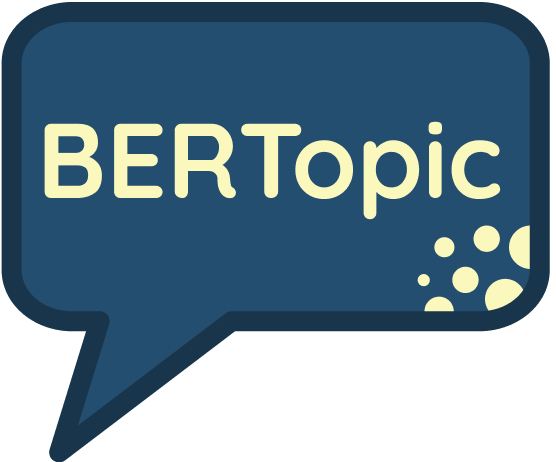

<hr />
<h3 id="imports">Imports</h3>

In [ ]:
#!pip install zstandard

import os
import requests
import json
import numpy as np
import pandas as pd
#import zstandard as zstd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
# Display Options
pd.options.display.float_format = '{:,.2f}'.format

#Variables
MAX_SEQUENCE_LENGTH = 700
MAX_NUM_WORDS = 10000
EMBEDDING_DIM = 100

<p> The main libraries used for this project are Tensorflow and the high level API Keras which enable fast prototyping for projects and research.  Tensorflow has integrated Keras into its library and can now be accessed directly from Tensorflow.  We also import Pandas, Numpy, and Scikit-Learn to assist in our data wrangling </p>

<hr />
<h3 id="data-wrangling">Data Wrangling</h3>




<p> There are several ways to grab comment data from Reddit but I found the fastest and most comprehensive way was to use <a href="https://files.pushshift.io/reddit/comments/">pushift.</a> which has already done a bulk of the work for us.  Each file contains comments made on Reddit for a particular time period.  Since each file contains millions of comments we are only going to download the most recent file. </p>



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Extract Data from zst file
# https://www.reddit.com/r/pushshift/comments/ajmcc0/information_and_code_examples_on_how_to_use_the/

fields = ['body', 'created_utc', 'id', 'is_submitter', 'link_id', 'score', 'subreddit_id', 'subreddit'] 

with open("/content/drive/MyDrive/Data_Science/Reddit/Copy of Military_comments.zst", 'rb') as fh:
    dctx = zstd.ZstdDecompressor()
    with dctx.stream_reader(fh) as reader:
        previous_line = ""
        count = 1
        while True:
            chunk = reader.read(2**24)
            if not chunk:
                break
                
            string_data = chunk.decode('utf-8')
            lines = string_data.split("\n")
            comments = []
            
            for i, line in enumerate(lines[:-1]):
                if i == 0:
                    line = previous_line + line
                object = json.loads(line)
                    
                if object['body'] in ['[deleted]', '[removed]'] or \
                    object['parent_id'].startswith('t1'):          
                    pass
                else:
                    object = dict((k, object[k]) for k in fields if k in object)
                    
                    comments.append(object)
                    
            df = pd.DataFrame(comments)
            
            df.to_csv(f'/content/drive/MyDrive/Data_Science/Reddit/Copy of Military_{count}_comments.csv', index=False)
            count += 1         
              
            previous_line = lines[-1]

<p> The zst file is too big to read into memory all at once.  The above code loops through the file from pushift and stores chunks of comments into individual csv files.  In order to further reduce the size we also limit the comments to the politics subreddit.  The politics subreddit has a consistent narrative therefore it might not be as eratic as other subreddits when it comes to comment score. </p>

In [ ]:
military_comments_1 = pd.read_csv('/content/drive/MyDrive/Data_Science/Reddit/Copy of Military_1_comments.csv')

In [ ]:
military_comments_1.head()

,body,created_utc,id,link_id,score,subreddit_id,subreddit
0,"&gt;""Surveillance with teeth."" \n\nYeah, becau...",1204133841,c03am9s,t3_6a53g,0,t5_2qh8y,Military
1,[Mission creep: the militarizing of America](h...,1204276433,c03b8c6,t3_6adxv,1,t5_2qh8y,Military
2,American troops are already insane to go to an...,1204815260,c03dbrm,t3_6b3ag,2,t5_2qh8y,Military
3,"look, i obviously can't defend the guy, but wh...",1205129479,c03egq1,t3_6bh27,1,t5_2qh8y,Military
4,A lot of people ended up doing shit like that....,1205165535,c03ekga,t3_6bigt,1,t5_2qh8y,Military


filepaths = [f'/content/drive/MyDrive/Data_Science/Reddit/military_comments/{file}' for file in os.listdir(r'/content/drive/MyDrive/Data_Science/Reddit/military_comments/')]
df = pd.concat(map(pd.read_csv, filepaths))
df = df.reset_index(drop=True)
df.to_csv('//content/drive/MyDrive/Data_Science/Reddit/military_comments/military_comments_merged.csv', index=False)

In [ ]:
#Start here if loading from csv

df = pd.read_csv('//content/drive/MyDrive/Data_Science/Reddit/military_comments/military_comments_merged.csv')


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df.shape

(1679726, 8)

In [ ]:
#Convert unix time to utc time
df['date'] = pd.to_datetime(df['created_utc'],unit='s')
df.head()

,body,created_utc,id,link_id,score,subreddit_id,subreddit,is_submitter,date
0,"&gt;""Surveillance with teeth."" \n\nYeah, becau...","1,204,133,841.00",c03am9s,t3_6a53g,0.00,t5_2qh8y,Military,NaN,2008-02-27 17:37:21
1,[Mission creep: the militarizing of America](h...,"1,204,276,433.00",c03b8c6,t3_6adxv,1.00,t5_2qh8y,Military,NaN,2008-02-29 09:13:53
2,American troops are already insane to go to an...,"1,204,815,260.00",c03dbrm,t3_6b3ag,2.00,t5_2qh8y,Military,NaN,2008-03-06 14:54:20
3,"look, i obviously can't defend the guy, but wh...","1,205,129,479.00",c03egq1,t3_6bh27,1.00,t5_2qh8y,Military,NaN,2008-03-10 06:11:19
4,A lot of people ended up doing shit like that....,"1,205,165,535.00",c03ekga,t3_6bigt,1.00,t5_2qh8y,Military,NaN,2008-03-10 16:12:15


In [ ]:
#Delete unneeded columns
df.drop(columns=['created_utc', 'id', 'link_id', 'subreddit_id', 'subreddit', 'is_submitter'], inplace=True)

<p>Finally we take the individual csv files and merge them into a single csv file. </p>

<hr />
<h3 id="data-exploration">Data Exploration</h3>

In [ ]:
#Clean the qrcs before DTM

df['body'] = df['body'].str.lower().replace(r"http\S+", "", regex=True)
df['body'] = df['body'].str.replace("redacted contact", "", regex=True)
df['body'] = df['body'].str.replace('/[^a-zA-Z0-9 ]/g', '', regex=True)
df['body'].replace('nan', np.nan)
df.dropna(subset=['body', 'date'], inplace=True)
df.tail()

,body,score,date
1679721,looks pretty normal to me. a bunch of young ki...,1.00,2022-12-31 23:56:00
1679722,are soldiers not supposed to be human &amp; ha...,1.00,2022-12-31 23:57:51
1679723,hi! this is our community moderation bot.\n\n-...,1.00,2022-12-31 23:58:54
1679724,i think that anyone who posts nonsense like th...,1.00,2022-12-31 23:59:45
1679725,&gt;the us is concerned by china's alignment w...,1.00,2022-12-31 23:59:57


In [ ]:
#Pick 200k random rows for modeling to speed up process

df_random = df.sample(200000)


In [ ]:
# Filter

df_timestamps = df_random.date.to_list()
df_list = df_random.body.to_list()


# **Dynamic Topic Modeling**


## Basic Topic Model
To perform Dynamic Topic Modeling with BERTopic we will first need to create a basic topic model using all tweets. The temporal aspect will be ignored as we are, for now, only interested in the topics that reside in those tweets. 

In [1]:
!pip install bertopic

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english")
topic_model = BERTopic(min_topic_size=200, vectorizer_model=vectorizer_model, calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(df_list)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 60.4 MB/s eta 0:00:00
  Installing build dependencies ... canceled
ERROR: Operation cancelled by user


ModuleNotFoundError: ignored

In [ ]:

topic_model.save("Reddit_Military_comments")

/usr/local/lib/python3.8/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [ ]:
my_model = BERTopic.load("Reddit_Military_comments")

FileNotFoundError: ignored

In [ ]:
freq = topic_model.get_topic_info()

In [ ]:
topics_to_merge = [[-1, 3, 12, 10, 15, 32, 30, 26, 37, 38, 40, 43, 46, 47, 51, 54, 55, 58, 64, 71, 77, 78, 83, 94, 96, 98, 99, 100, 101, 103, 105, 106, 108],#meaningless
                   [20, 38, 52, 86],#politics 
                   [6, 44, 48, 79, 84, 87], #branches
                   [8, 18, 29, 35, 57, 80, 85, 88], #dress
                   [14, 17, 32, 41], #training
                   [1, 6, 16, 21, 22, 39, 49, 56, 61, 63, 69, 73, 92], #wars/other countries
                   [2, 24], #college/rotc
                   [20, 34, 70], #aircraft
                   [13], #bases
                   [9], #finances
                   [4], #spouse
                   [26, 76], #medical
                   [11, 43], #veterans
                   [45], #music
                   [33, 42, 82, 97, 102], #enlisting
                   [72], #pets
                   [25, 28, 97],  #health
                   [74, 50] #rank
               ]
topic_model.merge_topics(df_list, topics_to_merge)

In [ ]:
pd.set_option('max_rows', 110)
freq

,Topic,Count,Name
0,-1,113020,-1_just_like_dont_people
1,0,4827,0_gun_rifle_ammo_weapon
2,1,3527,1_ukraine_russia_russian_russians
3,2,3245,2_rotc_college_officer_job
4,3,2911,3_comment_post_downvote_moderation
5,4,2356,4_shes_married_wife_marriage
6,5,2128,5_navy_ship_ships_submarine
7,6,2075,6_marines_marine_corps_army
8,7,1962,7_food_mres_mre_eat
9,8,1918,8_uniform_wear_uniforms_dress


In [ ]:
topic_model.get_topic(5)

[('marines', 0.06949152559532706),
 ('marine', 0.053858178462882905),
 ('force', 0.04014004787585698),
 ('air', 0.029050782476275436),
 ('seals', 0.027917167550719206),
 ('ranger', 0.027007738250148256),
 ('seal', 0.02597655862899763),
 ('coast', 0.023616850048621532),
 ('corps', 0.021309930716596974),
 ('space', 0.021188650930758432)]

In [ ]:
fig = topic_model.visualize_topics(); fig

## Topics over Time
Before we start with the Dynamic Topic Modeling step, it is important that you are satisfied with the topics that were created previously. We are going to be using those specific topics as a base for Dynamic Topic Modeling. 

Thus, this step will essentially show you how the topics that were defined previously have evolved over time. 

There are a few important parameters that you should take note of, namely:

* `docs`
  * These are the tweets that we are using
* `timestamps`
  * The timestamp of each tweet/document
* `global_tuning`
  * Whether to average the topic representation of a topic at time *t* with its global topic representation
* `evolution_tuning`
  * Whether to average the topic representation of a topic at time *t* with the topic representation of that topic at time *t-1*
* `nr_bins`
  * The number of bins to put our timestamps into. It is computationally inefficient to extract the topics at thousands of different timestamps. Therefore, it is advised to keep this value below 20. 


In [ ]:
df_timestamps[0:5]

[Timestamp('2016-12-12 18:36:27'),
 Timestamp('2013-01-01 18:34:49'),
 Timestamp('2014-05-01 02:50:31'),
 Timestamp('2021-07-14 13:55:12'),
 Timestamp('2022-06-05 13:18:13')]

In [ ]:
topics_over_time = topic_model.topics_over_time(docs=df_list, 
                                                timestamps=df_timestamps, 
                                                global_tuning=True, 
                                                evolution_tuning=True, 
                                                nr_bins=20)

20it [00:24,  1.24s/it]


## Visualize Topics over Time
After having created our `topics_over_time`, we will have to visualize those topics as accessing them becomes a bit more difficult with the added temporal dimension. 

To do so, we are going to visualize the distribution of topics over time based on their frequency. Doing so allows us to see how the topics have evolved over time. Make sure to hover over any point to see how the topic representation at time *t* differs from the global topic representation. 


In [ ]:
topic_model.visualize_topics_over_time(topics_over_time, topics = [0,1,2,3])

In [ ]:
topic_model.visualize_topics_over_time(topics_over_time, topics = [4,5,6,7,8,9])

In [ ]:
topic_model.visualize_barchart(top_n_topics = 13)

In [ ]:
topic_model.visualize_heatmap(top_n_topics = 27, n_clusters = 5)
